In [44]:
from tslearn.utils import to_time_series_dataset
from tensorflow.keras.preprocessing import timeseries_dataset_from_array
from keras.models import Sequential
from keras.layers import LSTM, Dense, RepeatVector, TimeDistributed, Dropout

import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import pickle
import numpy as np
import seaborn as sns

In [2]:
with open('data/interfusion/processed/omi-1_train.pkl', 'rb') as f:
    train = pickle.load(f)

In [3]:
with open('data/interfusion/processed/omi-1_test.pkl', 'rb') as f:
    test = pickle.load(f)

In [4]:
with open('data/interfusion/processed/omi-1_test_label.pkl', 'rb') as f:
    anomalies_omi1 = pickle.load(f)
    anomalies_omi1 = np.flatnonzero(anomalies_omi1)

In [5]:
train.shape

(8640, 19)

In [6]:
anomalies_omi1.shape

(441,)

In [7]:
test.shape

(4320, 19)

In [10]:
# rows = int(np.ceil(np.sqrt(len(train[0]))))
# cols = int(np.floor(np.sqrt(len(train[0]))))
# fig, axs = plt.subplots(rows, cols, figsize = (40,40))
#
# for i in range(rows):
#     for j in range(cols):
#         if i*cols+j+1>len(train[0]): # pass the others that we can't fill
#             continue
#         axs[i, j].plot(train[:,i*cols+j])
#         for anomaly in anomalies_omi1:
#             axs[i, j].axvline(anomaly, color='red', alpha=0.5)
#
# plt.show()

In [11]:
def split_sequence(sequence, n_steps_in, n_steps_out):
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        # check if we are beyond the sequence
        if out_end_ix > len(sequence):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [37]:
n_steps_in = 12
n_steps_out = 12
# reshape to 3D [n_samples, n_steps, n_features]
X_train, y_train = split_sequence(train, n_steps_in, n_steps_out)
X_test, y_test = split_sequence(test, n_steps_in, n_steps_out)
# reshape from [samples, timesteps] into [samples, timesteps, features]
n_features = 19
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], n_features))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], n_features))
print('X_train shape:', X_train.shape)
print('y_train shape:', y_train.shape)
print('X_test shape:', X_test.shape)
print('y_test shape:', y_test.shape)

X_train shape: (8617, 12, 19)
y_train shape: (8617, 12, 19)
X_test shape: (4297, 12, 19)
y_test shape: (4297, 12, 19)


In [38]:
units = 64
dropout = 0.2
optimizer = 'adam'
loss = 'mae'
epochs = 20

model = Sequential()
model.add(LSTM(units, input_shape=(n_steps_in, n_features)))
model.add(Dropout(rate=dropout))
model.add(RepeatVector(n_steps_out))
model.add(LSTM(units, return_sequences=True))
model.add(Dropout(rate=dropout))
model.add(TimeDistributed(Dense(n_features)))
model.compile(optimizer='adam', loss='mae')

In [39]:
# fit model
history = model.fit(X_train, y_train, epochs=epochs, validation_split=0.1, batch_size=32, shuffle=False)

Epoch 1/20
243/243 [==============================] - 6s 12ms/step - loss: 0.1321 - val_loss: 0.0590
Epoch 2/20
243/243 [==============================] - 2s 10ms/step - loss: 0.0736 - val_loss: 0.0421
Epoch 3/20
243/243 [==============================] - 2s 10ms/step - loss: 0.0594 - val_loss: 0.0413
Epoch 4/20
243/243 [==============================] - 2s 9ms/step - loss: 0.0541 - val_loss: 0.0356
Epoch 5/20
243/243 [==============================] - 2s 9ms/step - loss: 0.0483 - val_loss: 0.0345
Epoch 6/20
243/243 [==============================] - 2s 9ms/step - loss: 0.0455 - val_loss: 0.0338
Epoch 7/20
243/243 [==============================] - 2s 9ms/step - loss: 0.0430 - val_loss: 0.0329
Epoch 8/20
243/243 [==============================] - 2s 9ms/step - loss: 0.0406 - val_loss: 0.0304
Epoch 9/20
243/243 [==============================] - 2s 9ms/step - loss: 0.0400 - val_loss: 0.0327
Epoch 10/20
243/243 [==============================] - 2s 9ms/step - loss: 0.0391 - val_loss: 0.0

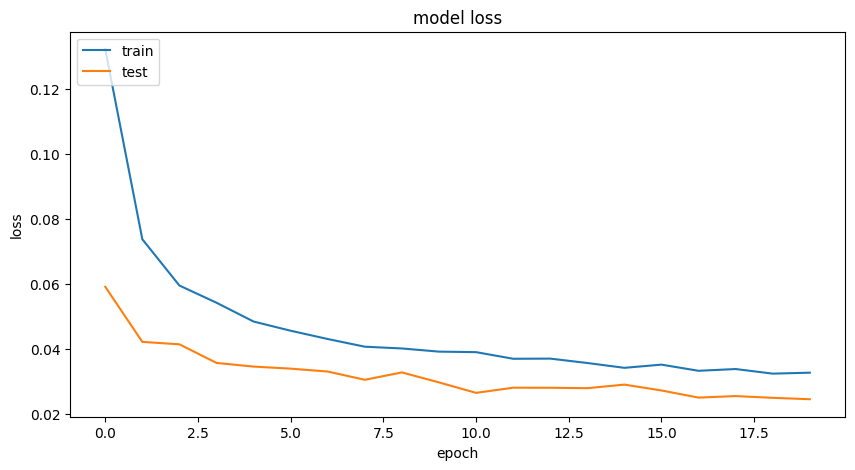

In [40]:
# history for loss
plt.figure(figsize = (10,5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

270/270 [==============================] - 1s 3ms/step
Training Loss: 0.04971727728843689



C:\Users\ric10\AppData\Local\Temp\ipykernel_36364\2811862076.py:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(train_loss, bins=50, kde=True)


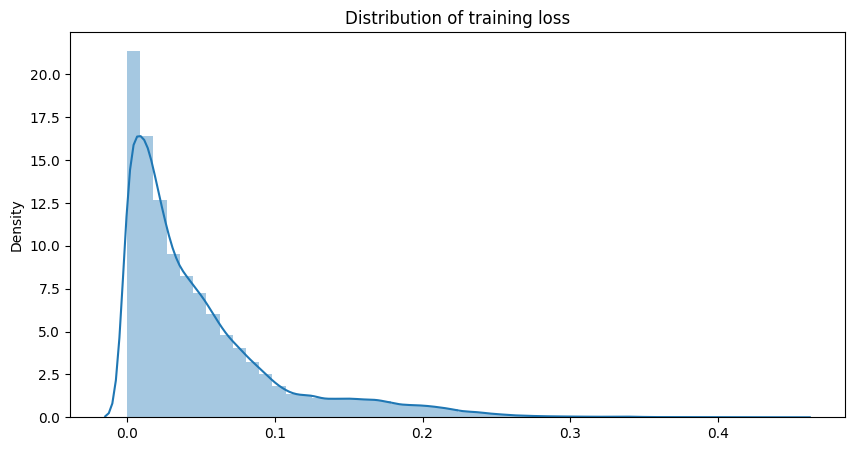

In [45]:
train_pred = model.predict(X_train)
train_loss = (np.mean(np.abs(train_pred - X_train), axis=1))
avg_loss = train_loss.mean()
print('Training Loss: {}\n'.format(avg_loss))

plt.figure(figsize=(10,5))
sns.distplot(train_loss, bins=50, kde=True)
plt.title('Distribution of training loss')
plt.show()

In [ ]:
# MAE on the test data:
y_pred = model.predict(X_test)
print('Predict shape:', y_pred.shape); print();
mae = np.mean(np.abs(y_pred - X_test), axis=1)
# reshaping prediction
pred = y_pred.reshape((y_pred.shape[0] * y_pred.shape[1]), y_pred.shape[2])
print('Prediction:', pred.shape); print();
print('Test data shape:', X_test.shape); print();
# reshaping test data
X_test = X_test.reshape((X_test.shape[0] * X_test.shape[1]), X_test.shape[2])
print('Test data:', X_test.shape); print();
# error computation
errors = X_test - pred
print('Error:', errors.shape); print();
# rmse on test data
RMSE = np.sqrt((np.square(X_test - pred_reshape)).mean(axis=ax))
print('Test RMSE: %.3f' % RMSE);